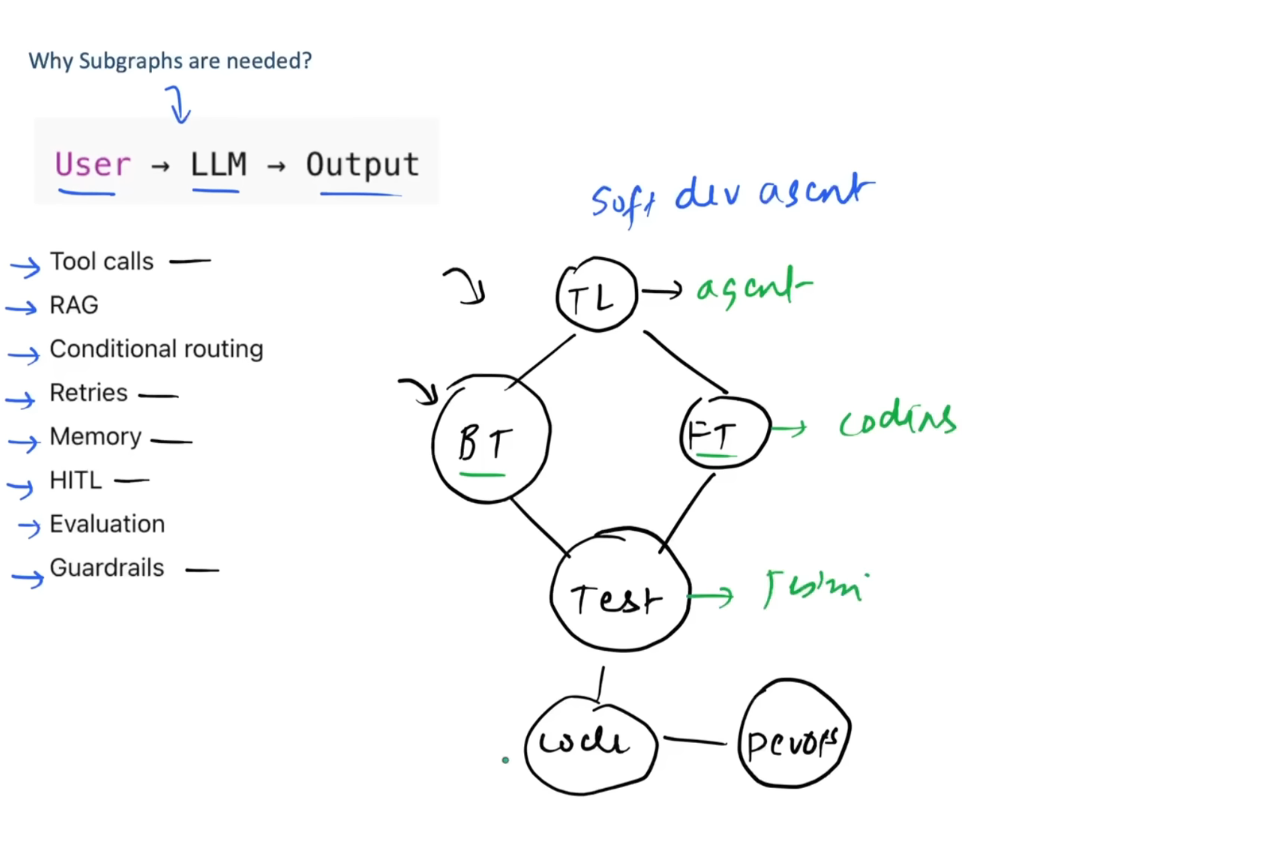

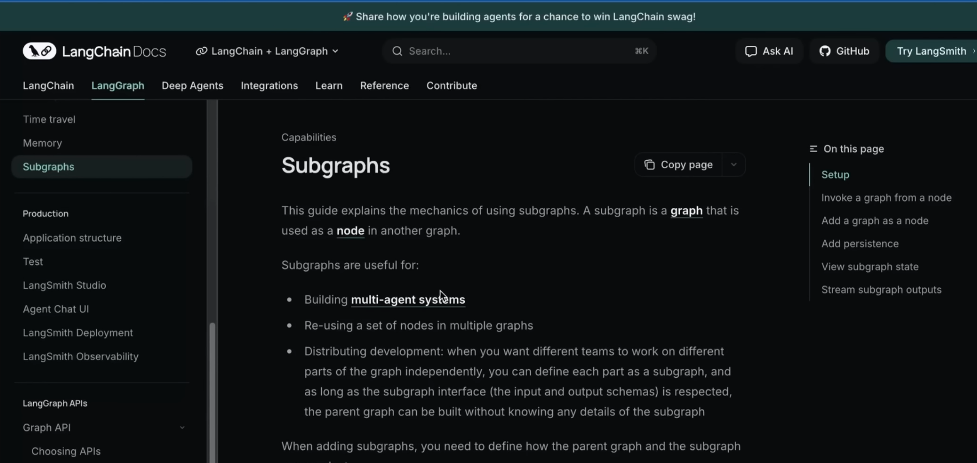

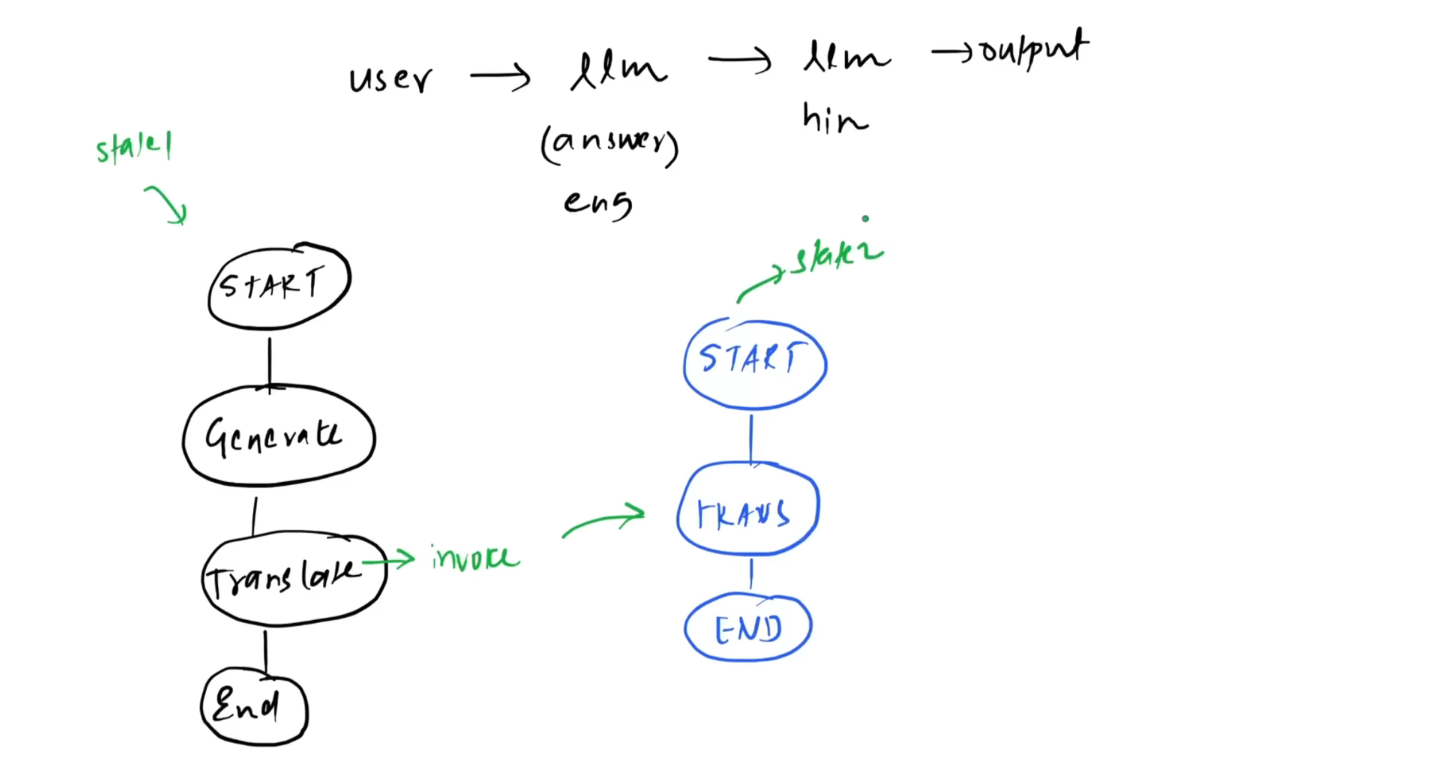


---

# 🧩 Concept: What Is a Subgraph?

A **Subgraph** is a self-contained LangGraph graph that is embedded and run as a single **Node** inside a **Parent Graph**.

### Mental Model

> Subgraphs are to LangGraph what **functions/classes/modules** are to large software projects.

### Realistic Analogy

A complex agent (e.g., “Software Development Agent”) can be decomposed:

```
Parent Graph (Team Lead)
 ├─ Backend Subgraph
 ├─ Frontend Subgraph
 ├─ Testing Subgraph
 └─ DevOps Subgraph
```

Each subgraph:

1. Has its own logic
2. May use its own tools
3. May have its own state schema

---

## 💡 Why Use Subgraphs?

### **Conceptual Advantages**

| Benefit         | Explanation                                                 |
| --------------- | ----------------------------------------------------------- |
| Modularity      | Break massive logic into manageable units                   |
| Reusability     | One “Translator Agent” can be reused in different workflows |
| Maintainability | Debugging is scoped to a smaller agent                      |

### **Technical Advantages (LangGraph specific)**

| Technical Benefit | Explanation                                          |
| ----------------- | ---------------------------------------------------- |
| Failure Isolation | Parent can catch child errors without global failure |
| State Separation  | Avoids variable collisions; private subgraph state   |
| Observability     | Independent traces for each subgraph in LangSmith    |

---


---

# 🏗️ Two Official Mechanisms to Implement Subgraphs

The video shows both patterns, each valid for different architectures.

---

# 🧱 **Mechanism A — Isolated State Subgraph (Parent Invokes)**

Parent and subgraph **do not share state**.
Parent manually passes data in/out.

### **Use Case**

* Translation pipeline
* Summarization pipeline
* Analysis → post-processing tasks

---

### **Example: English → Hindi Translation**

#### 1. **Subgraph Definition**

```python
from typing import TypedDict
from langgraph.graph import StateGraph

class SubState(TypedDict):
    input_text: str
    translated_text: str

def translate_logic(state: SubState):
    hindi = translate_to_hindi(state["input_text"])
    return {"translated_text": hindi}

sub_builder = StateGraph(SubState)
sub_builder.add_node("translate_node", translate_logic)
subgraph = sub_builder.compile()
```

#### 2. **Parent Node Wrapper (Manual Invocation)**

```python
def translation_node(state):
    response = subgraph.invoke({"input_text": state["english_answer"]})
    return {"hindi_answer": response["translated_text"]}
```

#### 3. **Parent Graph**

```python
parent_builder = StateGraph(dict)
parent_builder.add_node("generate_english", gen_logic)
parent_builder.add_node("translate_step", translation_node)
```

---

# 🧱 **Mechanism B — Shared State Subgraph (Graph-as-Node)**

Parent and subgraph **share the same state keys**.
Data flows automatically, no wrapper.

### **Use Case**

* Multi-phase single-document workflows
* Agents that modify and enrich shared state
* Multi-step pipelines with accumulation

---

### **Example: Shared State Translation**

```python
class SharedState(TypedDict):
    question: str
    english_answer: str
    hindi_answer: str

sub_builder = StateGraph(SharedState)
sub_builder.add_node("translate_node", translate_logic)
subgraph = sub_builder.compile()

parent_builder = StateGraph(SharedState)
parent_builder.add_node("generate_english", gen_logic)

parent_builder.add_node("translate_step", subgraph)
parent_builder.add_edge("generate_english", "translate_step")
```

---

# 📦 Production Suggestions from the Author (w/ Code)

The author suggested several production practices that weren’t in your summary. They are added here.

---

## **(A) Persistence: Checkpointer Shared Automatically**

> If you apply a checkpointer to the Parent Graph, you do **not** apply one to the subgraph.

### **Code**

```python
from langgraph.checkpoint.sqlite import SqliteSaver

checkpointer = SqliteSaver.from_file("state.db")
app = parent_builder.compile(checkpointer=checkpointer)
```

Result:

* Subgraph persists without extra configuration
* HITL + retries + recovery work by default

---

## **(B) Streaming From Subgraphs**

Streaming is often required to show intermediate tokens from child agents.

### **Code**

```python
for event in app.stream(input):
    if event["event"] == "on_update":
        print(event["data"])
```

LangGraph ensures:

* parent streams child tokens
* no double buffering
* predictable ordering

---

## **(C) Inspecting Subgraph State**

Subgraph state is inspectable via tracing:

```python
trace = app.trace(input)
trace.subgraphs[0].state
```

Useful for:

* debugging
* cost accounting
* provenance analysis

---

# 🔍 Q&A (Clarifications from Real Use)

**Q: Can subgraphs call HITL?**
**A:** Yes. HITL works recursively and checkpointing bubbles upward.

---

**Q: Can subgraphs have tools?**
**A:** Yes. Tools can be:

* only in parent
* only in child
* or both

---

**Q: Can a subgraph fail without killing parent?**
**A:** Yes. Parent may wrap via retry strategies or error nodes.

---

# 🧨 Edge Cases & Adversarial Scenarios

| Condition                | Problem                   | Mitigation             |
| ------------------------ | ------------------------- | ---------------------- |
| State Clashes            | duplicate keys            | use isolated schema    |
| Tool Conflicts           | same-name tool collisions | namespace tools        |
| Recursive Calls          | uncontrolled loops        | depth limits           |
| Ambiguous Responsibility | subgraph does wrong job   | define task boundaries |
| Observability Noise      | parent+child spam logs    | structured traces      |
| Massive Subgraphs        | startup cost increases    | lazy compilation       |

---

# 🌉 Transition Into Multi-Agent Systems

Subgraphs unlock:

* Researcher → Writer
* Planner → Executor
* Decomposer → Solver → Judge



